# Colocate ICESat-2 and TOPAZ

# _______________________________________

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from glob import glob
import netCDF4 as nc4
import pyproj

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl  # for size of 1st point of ICESat-2 along track data


from src.utils import save_name
from src.utils import modif_plot
from src.utils import quickplot
from src.utils import npstere_zoom

from src.data_preparation import load_data

In [2]:
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [24]:
# -----------------------------------
#             Load ICESat2
# -----------------------------------

# for each day, load filenames
# compute colocalisation for each trace: get SIT from 1 trace for all 3 beams

day = datetime.datetime(2018,10,14)
# to datetime.datetime(2022,04,30)
ifolder = f'{day.strftime("%Y%m%d")}'
idir = f'{rootdir}Leo/SIT_observations/IS2SITDAT4/{ifolder}/'

In [ ]:
# only 'high' resolution = strong beams
# = bnum1gt1r, bnum3gt2r, bnum5gt3r  for ATLAS forward orientation
# = bnum1gt1l, bnum3gt2l, bnum5gt3l  for ATLAS backward orientation
# 2018 - forward 
# 2 oct 2021 - switch to backward
# 9 june 2022 - switch to frontward
# 9 feb 2023 - switch to backward

In [25]:
list_filename = sorted(glob(os.path.join(idir,f'*.nc')))

In [26]:
filename = list_filename[0]

In [27]:
# variables of sea ice thickness:
# - ice_thickness: Sea ice thickness from ATL10 and redistributed NESOSIM (v1.1) snow loading
# - ice_thickness_W99mod5dist: Sea ice thickness from redistributed modified Warren snow loading
# - ice_thickness_unc: Total sea ice thickness uncertainty
# - ice_thickness_uncsys: Systematic sea ice thickness uncertainty
# - ice_thickness_uncrandom: Random sea ice thickness uncertainty

nc = nc4.Dataset(filename, mode='r')
sit_is = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['ice_thickness']
lat = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['latitude']
lon = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['longitude']
dist = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['along_track_distance']


# sit_is, chrono = load_data.load_nc(list_filename[0], 'ice_thickness', X_only=True)

In [28]:
# Project IS2 to TOPAZ projected coordinates

# Define the input and output coordinate systems
in_proj = pyproj.CRS('EPSG:4326')  # WGS 84 - lat/lon
# out_proj = pyproj.CRS('EPSG:3995')  # North Polar Stereographic

# define TOPAZ projection: a bit offset compared to North Polar Stereographic
proj_str = ('+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=10901.11 +y_0=10901.447')
out_proj = pyproj.CRS(proj_str)

In [29]:
# Create a transformer to convert from lat/lon to North Polar Stereographic
transformer = pyproj.Transformer.from_crs(in_proj, out_proj)

# Define the latitude and longitude to convert
lon0, lat0 = -105.2705, 80.0150

# Convert the latitude and longitude to North Polar Stereographic
x, y = transformer.transform(lat,lon)

x, y = x/1e5, y/1e5  # from m to 100 km (used in Topaz)

# Print the resulting x and y coordinates
# print("North Polar Stereographic Coordinates: ", x, y)

In [30]:
# sit_is0 = (sit_is.where((0<=sit_is), -999))#.where(np.isfinite(sit_is))  # exclude open ocean (SIT=0m)

In [31]:
sit_is0 = sit_is.where(sit_is>0, -999)

In [32]:
bin_width = 0.1
bins = np.arange(0,8+bin_width,bin_width) 

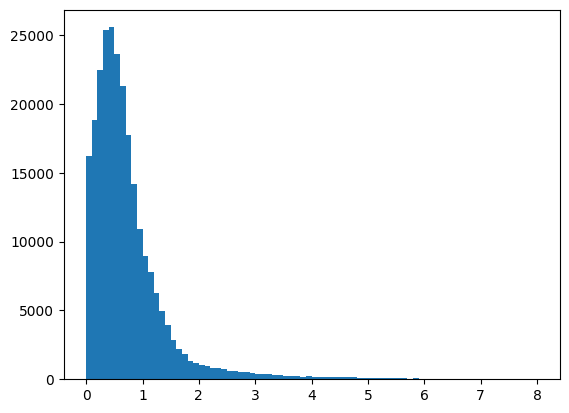

In [33]:
plt.hist(sit_is, bins=bins);

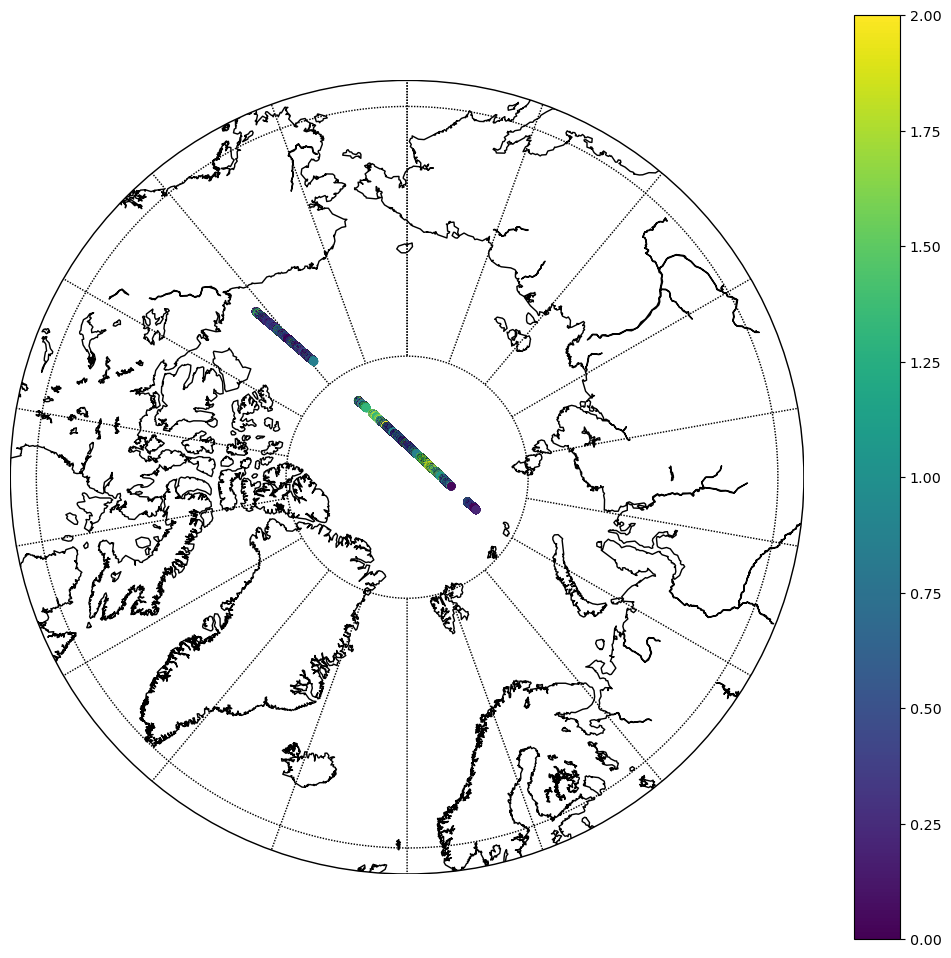

In [34]:
quickplot.basemap(lon, lat, var=sit_is, savefig=False, vmax=2, label='SIT (m)')


In [ ]:
# -----------------------------------
#         Load TOPAZ
# -----------------------------------

# global prediction RF:  (as example)
# filename = f'{rootdir}Leo/results/rf_221216-141433/ml/sit_ml_2011_2019.nc'

# filename = '/scratch/project_465000269/edelleo1/Leo/results/rf_221229-171734/ml/sit_ml_2000_2011.nc'
# ml_model = 'RF'

# filename = '/scratch/project_465000269/edelleo1/Leo/results/lstm_230201-112355/ml/sit_gLSTM_2000_2011.nc'
# ml_model = 'LSTM'


# sit_tp, chrono = load_data.load_nc(filename, 'sit_ml', X_only=True)
# sit, chrono = load_data.load_nc(filename, 'sit_na', X_only=True)


filename = f'{rootdir}Leo/results/pca_i100-550_j150-629/sithick_TOPAZ4b23_2011_2022.nc'
model = 'TP4b'
sit_tp, chrono = load_data.load_nc(filename, 'sithick', X_only=True)

# Cap negative value at 0 m (while keeping nan)
sit_tp = (sit_tp.where((0<=sit_tp), -999)).where(np.isfinite(sit_tp))  # exclude open ocean (SIT=0m)

In [60]:
filename = f'{rootdir}Leo/results/pca_i100-550_j150-629/sithick_TOPAZ4b23_2011_2022_FreeRun.nc'
# model = 'TP4'
sit, chrono = load_data.load_nc(filename, 'sithick', X_only=True)

In [29]:
day = datetime.datetime(2018,10,14)

In [38]:
# identify TOPAZ index for the corresponding day
chrono_dt = np.array([dt.date() for dt in chrono.date])
tidx = np.where(chrono_dt==day.date())[0]

if len(tidx) < 1:
    print('Day not found')
#     return
else:
    tidx = tidx[0]

In [ ]:
#x get same day

#x plot sit_is and sit_tp on basemap

#x see the resolution difference
#x -> to check on many observation can be colocated to 1 grid point in TOPAZ

# retrieve all of them: plot distribution


# best way to build the dataset: save to .nc ?

### -----------------

NameError: name 'nprof0' is not defined

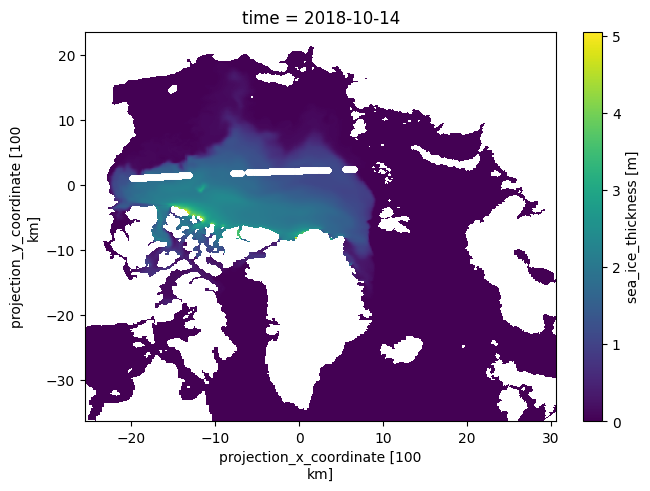

In [39]:
fig, ax = plt.subplots(nrows=1, constrained_layout=True)


sit_tp.isel(time=tidx).plot(ax=ax, vmin=0)
ax.plot(x, y, '.w', zorder=1)
nprof0.plot(ax=ax, alpha=0.3, vmax=500, cmap=plt.get_cmap('Reds'))

## PLOTS

In [190]:

def basemap_IS_TP(lats, lons, sit_is, lats2, lons2, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True, NpZoom=False, Zoom=[0, int(1e5)], **kwargs):
    '''
    Parameters:
    -----------
            lats         :        grid of latitude, dimension from sit_obs
            lons         :        grid of longitude
            sit_is       :        xr.DataArray, Sea Ice Thickness from ICESat-2
            lats2        :        grid of latitude, dimension from sit_tp
            lons2        :        grid of longitude
            sit_tp       :        xr.DataArray, Sea Ice Thickness from ToPaz
            
            NpZoom       :        bool. Basemap plot zoom on a smaller part
            Zoom         :        list of [1st profile, last profile] of ICESat-2 profiles to zoom on
    
    '''
    
    
    
    fig, axes = plt.subplots(ncols=1, figsize=(9, 9), constrained_layout=True)
    if NpZoom is False:
        m = Basemap(projection='npstere', boundinglat=68, lon_0=0, resolution='l', round=True, ax=axes)
    else:
        lonmin = lons[Zoom[0]] - .5
        lonmax = lons[Zoom[-1]] + .5
        latmin = lats[Zoom[0]] - .5
        latmax = lats[Zoom[-1]] + .5
#         print(lonmin, lonmax, latmin, latmax)
        m = npstere_zoom.mzoom(lonmin, lonmax, latmin, latmax)
        
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    
    # Plot ICESat-2
    m.scatter(lons, lats, c=sit_is, lw=0, latlon=True, zorder=100, **kwargs)
    m.scatter(lons[0], lats[0], c='#F2684C', latlon=True, marker='*', s=mpl.rcParams['lines.markersize'] ** 3, zorder=101)

    # Plot TOPAZ
    mlons2, mlats2 = m(lons2, lats2)
    
    cs2 = m.pcolormesh(mlons2, mlats2, sit_tp, zorder=0, **kwargs)   
    
    cbar=fig.colorbar(cs2, ax=axes, shrink=0.5, location="bottom", extend='max')
    cbar.set_label('SIT (m)')
    
    if 'vmin' in kwargs: 
        vmin = kwargs['vmin']
    else:
        vmin = cs2.colorbar.vmin
    if 'vmax' in kwargs: 
        vmax = kwargs['vmax']
    else:
        vmax = cs2.colorbar.vmax
    
    if 'vmin' in kwargs or 'vmax' in kwargs:
        cbar.set_ticks(np.arange(vmin,vmax+1,1))  # to get ticks integer only
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

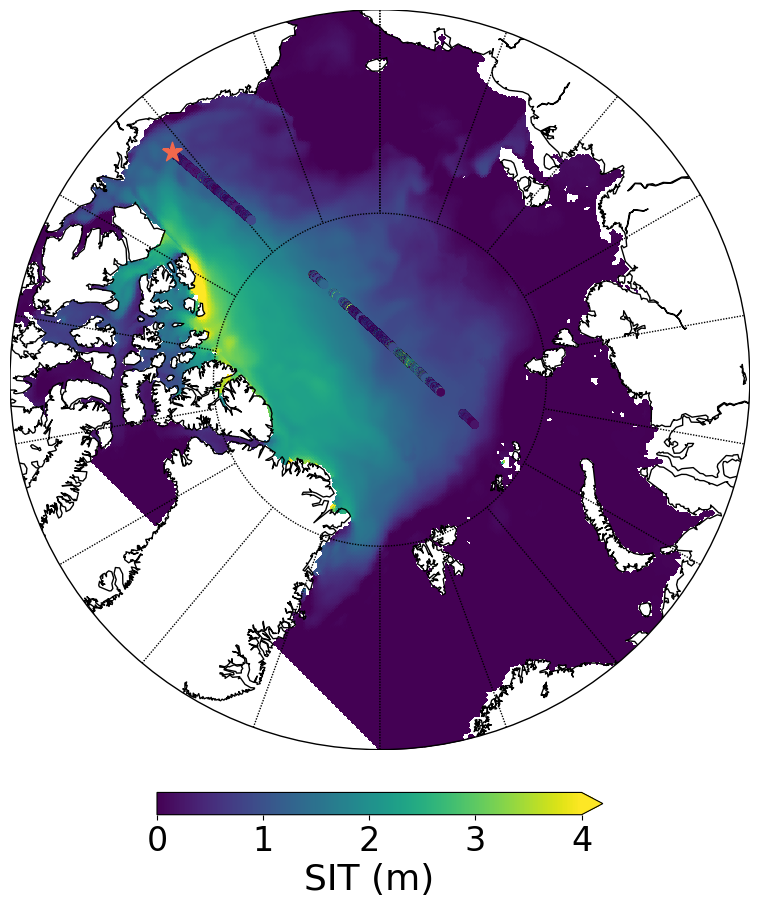

In [21]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, sit_tp.isel(time=tidx), vmin=0, vmax=4)

In [73]:
lat.size/100

2509.3

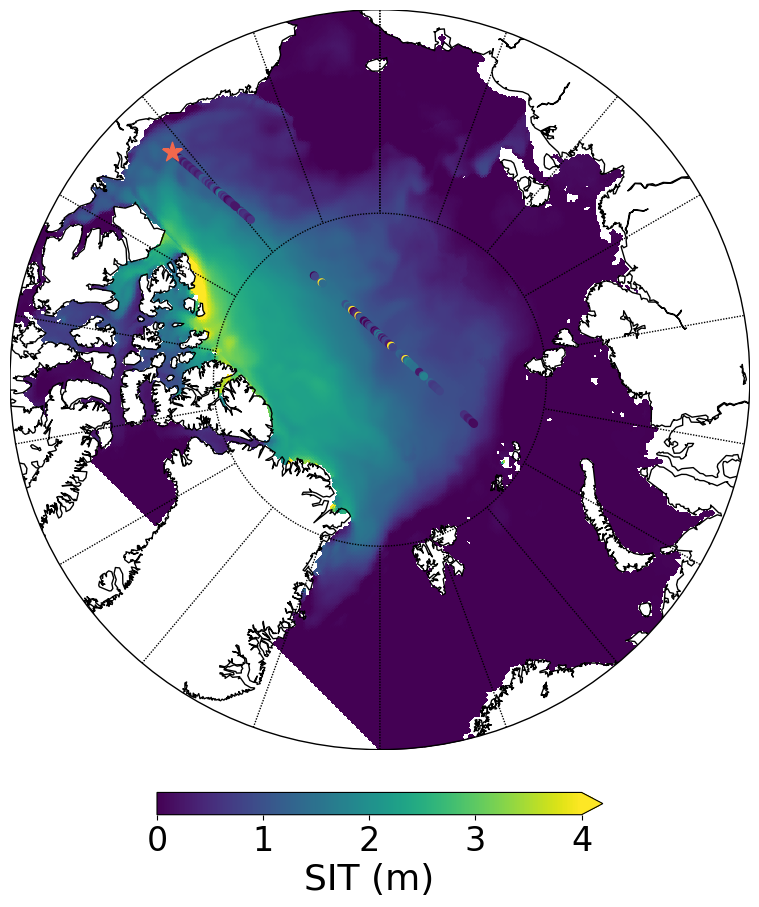

In [71]:
basemap_IS_TP(lat[::2000], lon[::2000], sit_is[::2000], sit_tp.latitude, sit_tp.longitude, sit_tp.isel(time=tidx), vmin=0, vmax=4)

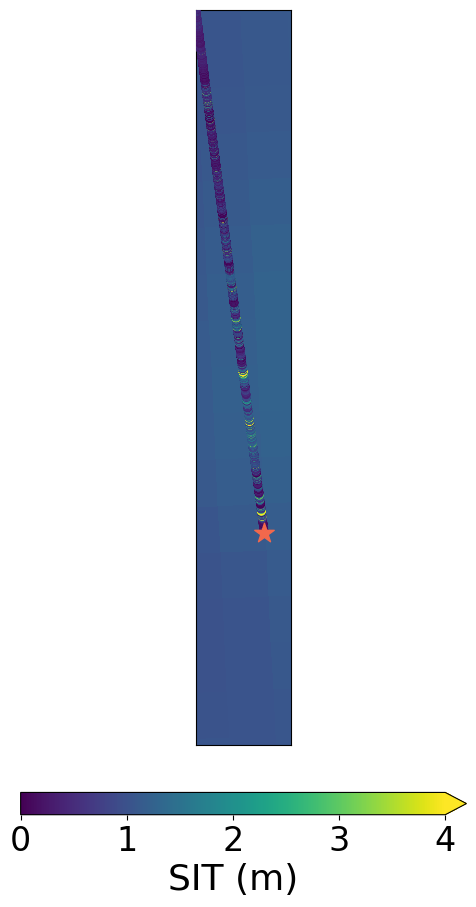

In [22]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, sit_tp.isel(time=tidx), vmin=0, vmax=4, 
              NpZoom=True, Zoom=[0,10000])

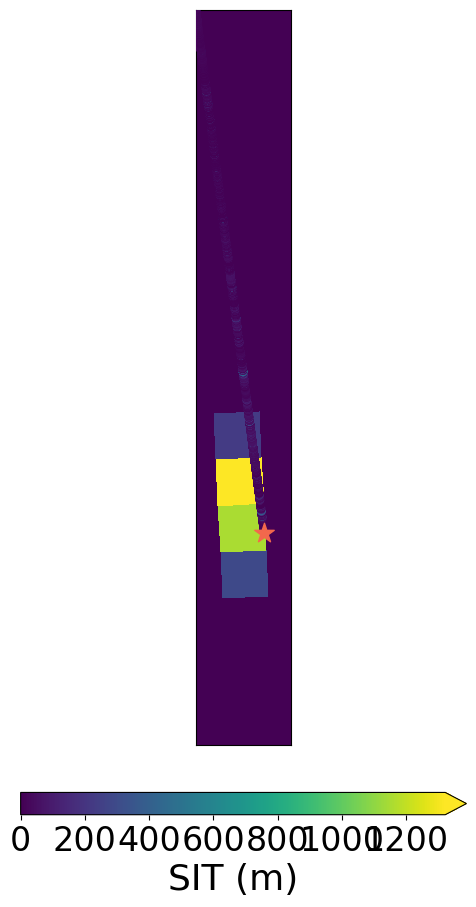

In [441]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof0,
              NpZoom=True, Zoom=[0,10000])

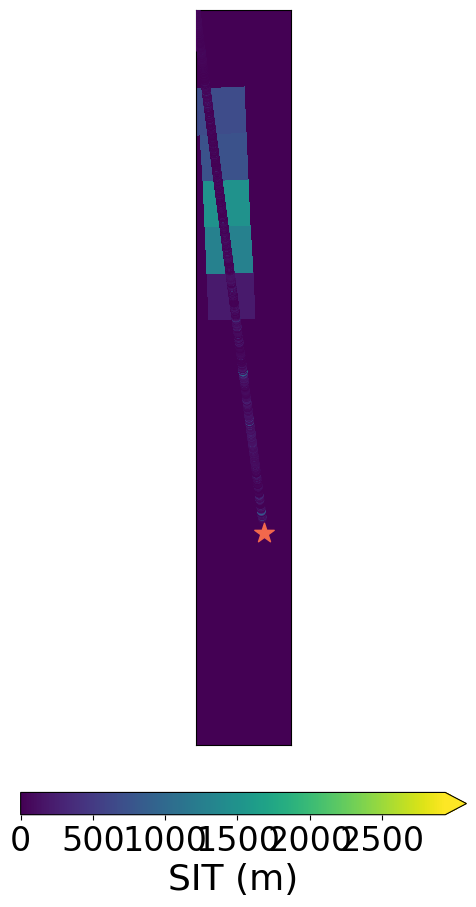

In [196]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof0,
              NpZoom=True, Zoom=[0,10000])

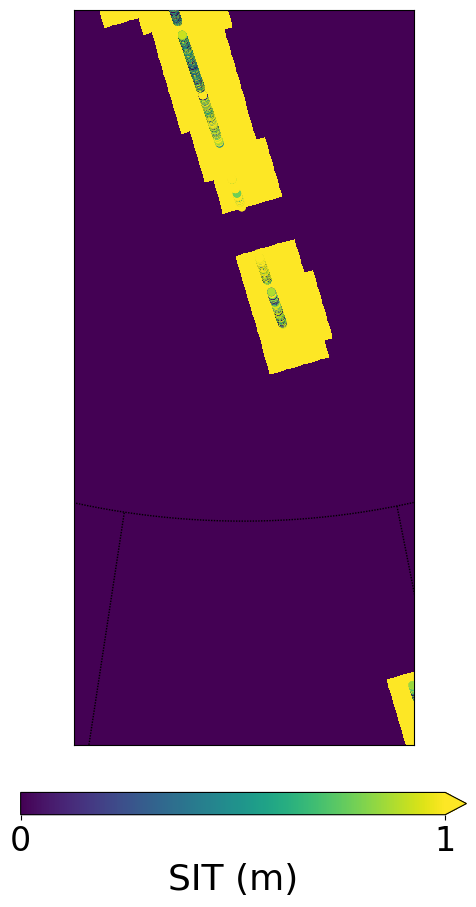

In [205]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, maskk, vmin=0, vmax=1, 
              NpZoom=True, Zoom=[int(10e4),int(13e4)])

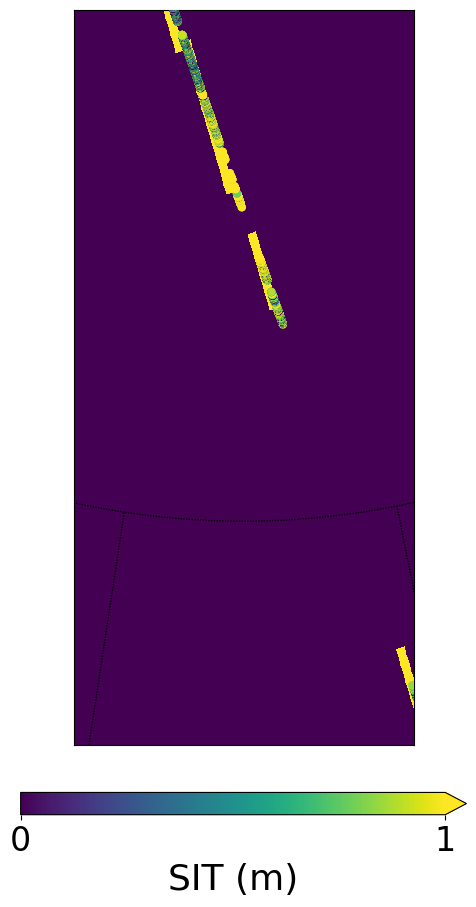

In [245]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof0, vmin=0, vmax=1, 
              NpZoom=True, Zoom=[int(10e4),int(13e4)])

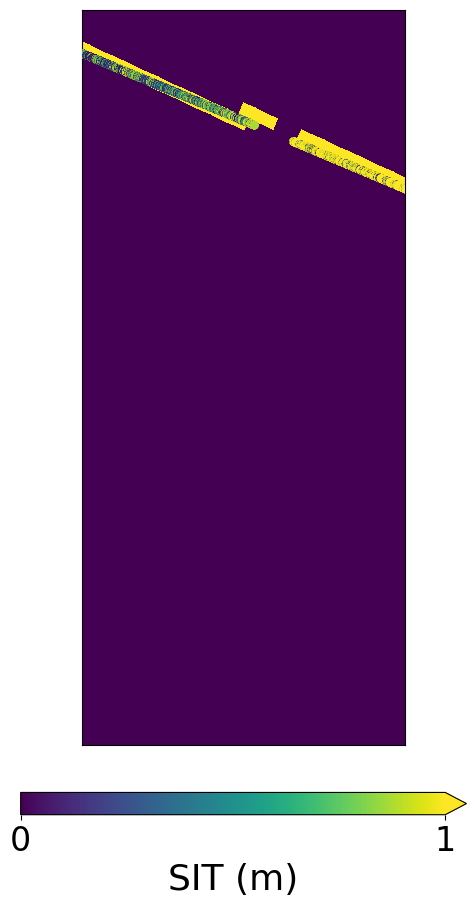

In [246]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof0, vmin=0, vmax=1, 
              NpZoom=True, Zoom=[int(16e4),int(20e4)])

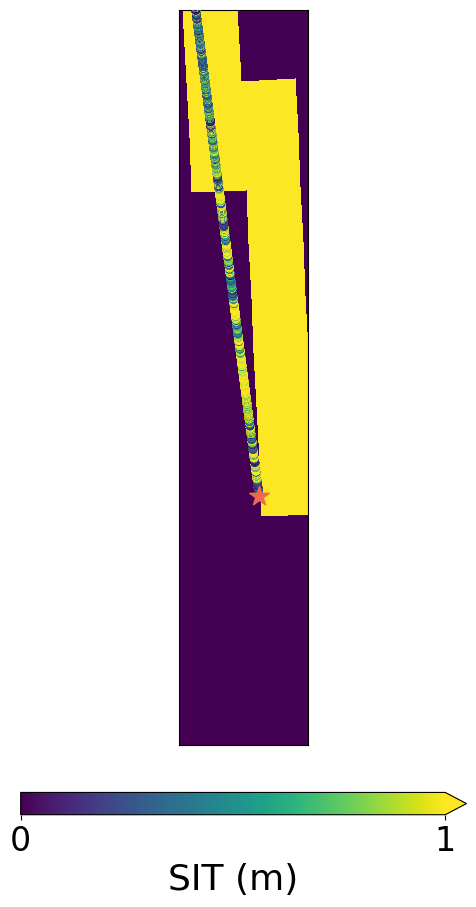

In [466]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof, vmax=1,
              NpZoom=True, Zoom=[0,5000])

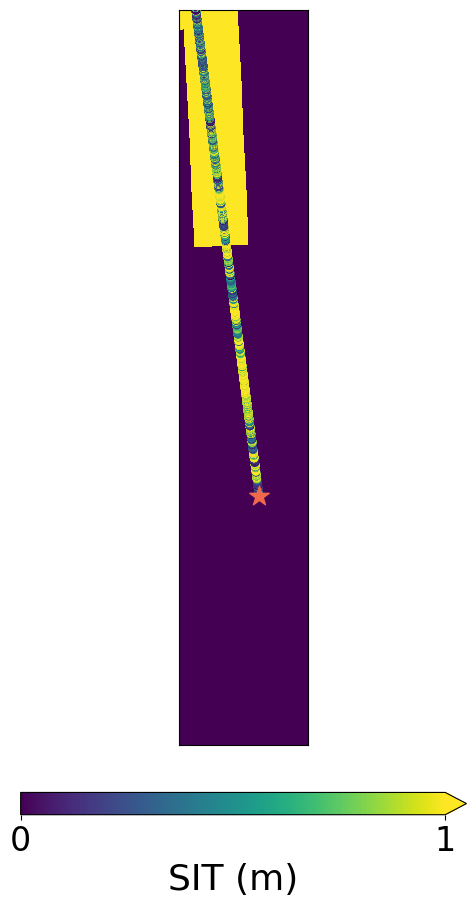

In [247]:
basemap_IS_TP(lat, lon, sit_is, sit_tp.latitude, sit_tp.longitude, nprof0, vmax=1,
              NpZoom=True, Zoom=[0,5000])

## Localise TOPAZ daily values to ICESat-2 profiles

In [40]:
def get_closest_arr_xy(ylat, xlon, sit_is, sit_tp):
    '''
    Returns ICESat-2 SIT (all points) for closest point in space and time
    for one given (lat, lon) "macropixel" from TOPAZ
    
    Parameters:
    -----------
        lat                 :    array of latitude of given points
        lon                 :    array of longitude of given points
        sit_is              :    xarray.DataArray, Sea Ice Thickness from ICESat-2
        sit_tp              :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
    
    Returns:
    --------
        sit                 : array of SIT from Topaz localisation in time and space with buoy
        lats                : array of valid lats
        lons                : array of valid lons
        valid               : valid lat lon points. may be non valid if time index is not found
    
    '''
    import time
    start = time.time()

    dmacro = {}   

    dy = sit_tp.y.to_numpy()[:, np.newaxis] - ylat
    dx = sit_tp.x.to_numpy()[:, np.newaxis] - xlon
        
    miny = np.argmin(abs(dy), axis=0)
    minx = np.argmin(abs(dx), axis=0)
        
    macro_idx = np.vstack((miny, minx))
        
    for idx in range(macro_idx.shape[1]):
        macro_name = f'{macro_idx[0][idx]}_{macro_idx[1][idx]}'
        if macro_name in dmacro:
            dmacro[macro_name].append(idx)
        else:
            dmacro[macro_name] = [idx]
    
    end = time.time()
    print('Time:  ', end - start, ' secs')
    
    return dmacro


In [ ]:
# returns indexes of profiles along-track
# in macro-pixel dico 

In [70]:
# dmac = get_closest_arr(lat[:1000], lon[:1000], sit_is, sit_tp.isel(time=tidx))

Time:   7.410999298095703  secs


In [41]:
dmac_xy = get_closest_arr_xy(y, x, sit_is, sit_tp.isel(time=tidx))

Time:   2.292776346206665  secs


In [42]:
dmac_xy.keys()

dict_keys(['298_44', '298_45', '298_46', '298_47', '298_48', '299_48', '299_49', '299_50', '299_51', '299_52', '299_53', '299_54', '299_55', '299_56', '299_57', '299_58', '299_59', '299_60', '300_60', '300_61', '300_62', '300_63', '300_64', '300_65', '300_66', '300_67', '300_68', '300_69', '300_70', '300_71', '300_72', '300_73', '301_73', '301_74', '301_75', '301_76', '301_77', '301_78', '301_79', '301_80', '301_81', '301_82', '301_83', '301_84', '301_85', '301_86', '301_87', '302_87', '302_88', '302_90', '302_91', '302_92', '302_93', '302_94', '302_95', '302_96', '302_97', '302_98', '302_99', '305_141', '305_142', '305_143', '305_144', '305_145', '305_146', '305_147', '305_148', '305_149', '306_155', '306_156', '306_157', '306_158', '306_159', '306_160', '306_161', '306_162', '306_163', '306_164', '306_165', '306_166', '306_167', '306_168', '306_169', '306_170', '306_171', '306_172', '307_172', '307_173', '307_174', '307_175', '307_176', '307_177', '307_178', '307_179', '307_180', '30

In [43]:
print(f'{len(list(dmac_xy.keys()))} TOPAZ Macro pixel with ICESat-2 profiles:')
[print(f'    {x}:  {len(dmac_xy[x])} profiles') for x in dmac_xy.keys()];

155 TOPAZ Macro pixel with ICESat-2 profiles:
    298_44:  206 profiles
    298_45:  1275 profiles
    298_46:  1481 profiles
    298_47:  737 profiles
    298_48:  676 profiles
    299_48:  629 profiles
    299_49:  1872 profiles
    299_50:  2371 profiles
    299_51:  2509 profiles
    299_52:  2481 profiles
    299_53:  2216 profiles
    299_54:  1940 profiles
    299_55:  1722 profiles
    299_56:  1493 profiles
    299_57:  1628 profiles
    299_58:  1236 profiles
    299_59:  1738 profiles
    299_60:  1416 profiles
    300_60:  228 profiles
    300_61:  1676 profiles
    300_62:  1691 profiles
    300_63:  1541 profiles
    300_64:  1946 profiles
    300_65:  2051 profiles
    300_66:  1542 profiles
    300_67:  2135 profiles
    300_68:  2090 profiles
    300_69:  1922 profiles
    300_70:  1937 profiles
    300_71:  2319 profiles
    300_72:  2230 profiles
    300_73:  1703 profiles
    301_73:  375 profiles
    301_74:  2279 profiles
    301_75:  2253 profiles
    301_76:  23

In [44]:
mpix = list(dmac_xy.keys())[40]

In [47]:
mpix = '298_46'

SIT for TOPAZ pixel "298_46": 1.3201420307159424 m
SIT averaged for ICESat-2: 1.028535588805428 m
Histogram for 1481 profiles from ICESat-2:


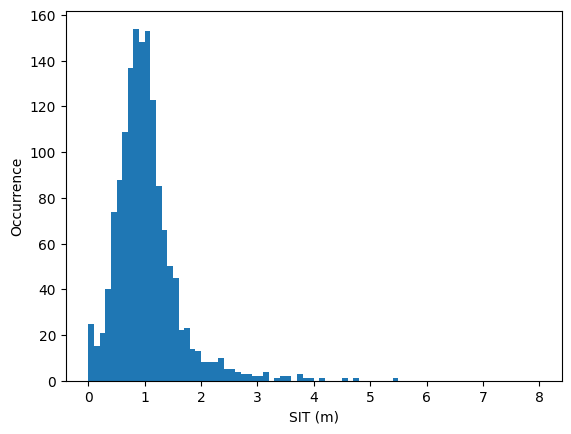

In [48]:
y_tp, x_tp = int(mpix.split('_')[0]), int(mpix.split('_')[1])
print(f'SIT for TOPAZ pixel "{mpix}": {sit_tp.isel(time=tidx,y=y_tp,x=x_tp).data} m')
print(f'SIT averaged for ICESat-2: {np.mean(sit_is.to_numpy()[dmac_xy[mpix]])} m')
print(f'Histogram for {len(dmac_xy[mpix])} profiles from ICESat-2:')
plt.hist(sit_is.to_numpy()[dmac_xy[mpix]], bins=bins)
plt.xlabel('SIT (m)')
plt.ylabel('Occurrence');

In [61]:
# n profiles per grid point
nproff0 = np.zeros((sit.shape))

In [62]:
for item in list(dmac_xy.keys()):
    my = int(item.split('_')[0])
    mx = int(item.split('_')[1])
    nproff0[my, mx] = len(dmac_xy[item])

In [63]:
nprof0 = xr.DataArray(nproff0,
                coords=sit.coords, 
                dims=sit.dims)

In [64]:
nproff0.shape

(4383, 479, 450)

AttributeError: Rectangle.set() got an unexpected keyword argument 'vmin'

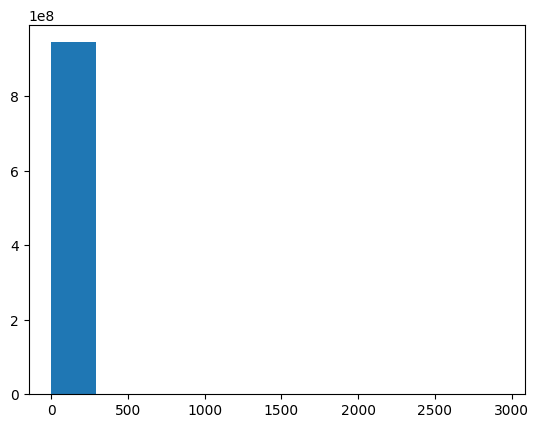

In [65]:
# nprof0.isel(y=slice(145,163)).plot(vmin=500)
nprof0.plot(vmin=500)

# ----------------------------------

### Draft

In [69]:
def get_closest_arr(lat, lon, sit_is, sit_tp):
    '''
    Returns ICESat-2 SIT (all points) for closest point in space and time
    for one given (lat, lon) "macropixel" from TOPAZ
    
    Parameters:
    -----------
        lat                 :    array of latitude of given points
        lon                 :    array of longitude of given points
        sit_is              :    xarray.DataArray, Sea Ice Thickness from ICESat-2
        sit_tp              :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
    
    Returns:
    --------
        sit                 : array of SIT from Topaz localisation in time and space with buoy
        lats                : array of valid lats
        lons                : array of valid lons
        valid               : valid lat lon points. may be non valid if time index is not found
    
    '''
    import time
    start = time.time()

    dmacro = {}   

    for pidx, (lt,ln) in enumerate(zip(lat,lon)):  # profile_idx
        # localise the closest TOPAZ points for the (lat, lon) point
        # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
        # First, find the index of the grid point nearest a specific lat/lon.   
        abslat = np.abs(sit_tp.latitude-lt)
        abslon = np.abs(sit_tp.longitude-ln)
        c = np.maximum(abslon, abslat)
        closest = np.where(c == np.min(c))

#         import pdb; pdb.set_trace()
        macro_name = f'{closest[0][0]}_{closest[1][0]}'
#         print(macro_name)
        if macro_name in dmacro:
            dmacro[macro_name].append(sit_is[pidx:pidx+1].data[0])
        else:
            dmacro[macro_name] = [sit_is[pidx:pidx+1].data[0]]
    
    end = time.time()
    print('Time:  ', end - start, ' secs')
    
    return dmacro


In [72]:
mpix = list(dmac.keys())[0]

SIT for TOPAZ pixel "148_38": 1.0724653903625643 m
SIT averaged for ICESat-2: 0.6025590687708923 m
Histogram for 294 profiles from ICESat-2:


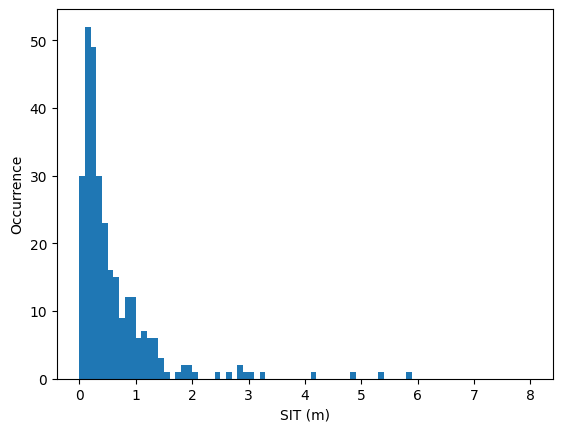

In [73]:
print(f'SIT for TOPAZ pixel "{mpix}": {sit_tp.isel(time=tidx,y=148,x=38).data} m')
print(f'SIT averaged for ICESat-2: {np.mean(dmac[mpix])} m')
print(f'Histogram for {len(dmac[mpix])} profiles from ICESat-2:')
plt.hist(np.array(dmac[mpix]), bins=bins)
plt.xlabel('SIT (m)')
plt.ylabel('Occurrence');

In [ ]:
# faster way to do the same thing (to try)

# identify TOPAZ grid points over the ICESat-2 track
# for each grid point:
    # get all profiles contains between latmin/latmax (+ lonmin/lonmax ?)
    # extract IS2 SIT for those pixels

In [100]:
lat_cut = lat[::2000]
lon_cut = lon[::2000]
sit = sit_tp.isel(time=tidx)

In [101]:
maskk = get_mask(lat[::500], lon[::500], sit)

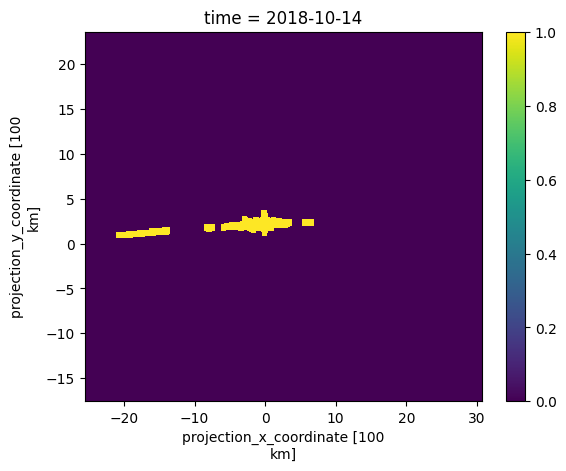

In [201]:
maskk.plot()

In [98]:
def get_mask(lat, lon, tp_grid):
    
    mask = np.zeros((tp_grid.shape))
    
    for pidx, (lt,ln) in enumerate(zip(lat,lon)):  # profile_idx
    # localise the closest TOPAZ points for the (lat, lon) point
    # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    # First, find the index of the grid point nearest a specific lat/lon.   
        abslat = np.abs(tp_grid.latitude-lt)
        abslon = np.abs(tp_grid.longitude-ln)
        c = np.maximum(abslon, abslat)
        closest = np.where(c == np.min(c))

        yloc = closest[0][0]
        xloc = closest[1][0]

        # get closest and put mask to true
        mask[yloc-4:yloc+3, xloc-4:xloc+3] = 1  # also surrounding pixel to be sure to not miss any profiles
               
    maskf = xr.DataArray(mask,
                    coords=tp_grid.coords, 
                    dims=tp_grid.dims)
    return maskf

In [477]:
import numpy as np
from math import pi

def equirec_array(lat2, lon2, lat1, lon1):
    """equirectangular distance approximation g distance petite
    Functions that calculate the distance between multiples points in 'lat2',
    'lon2' and the unique point in 'lat1', 'lon1'.


    Parameters
    ----------
    lat2,lon2:
               array_like, format (differents points, differentes coordonnees)
               Input array

    lat1, lon1 :
               array_like, format (, coordonnees 'de base')


    Returns
    -------
    d :  array_like
              'd' will have the same shape as 'lat2' ('lon2')
              format ()

    Exemple
    -------

    lat2 = np.array([[1, 2],
                     [47, 51],
                     [89, 87]])

    lon2 = np.array([[-1, 2],
                     [-5, 5],
                     [21, 18]])

    lat1 = np.array([0, 50, 90])
    lon1 = np.array([0, 0, 20])

    d = equirec_array(lta2, lon2, lat1, lon1)


    """
    R = 6371
    lat1 = (lat1*pi)/180
    lon1 = (lon1*pi)/180
    lon2 = (lon2*pi)/180
    lat2 = (lat2*pi)/180

    lon1 = np.tile(lon1, (lon2.shape[1], 1)).T
    lat1 = np.tile(lat1, (lat2.shape[1], 1)).T
    x = (lon2-lon1)*np.cos(0.5*(lat2+lat1))
    y = lat2-lat1
    return R * np.sqrt(x**2+y**2)

In [479]:
def loc_macrop_get_IS2(lat, lon, sit_is, sit_tp, verbose=1):
    '''
    Returns ICESat-2 SIT (all points) for closest point in space and time
    for one given (lat, lon) "macropixel" from TOPAZ
    
    Parameters:
    -----------
        lat                 :    array of latitude of given points
        lon                 :    array of longitude of given points
        sit_is              :    xarray.DataArray, Sea Ice Thickness from ICESat-2
        sit_tp              :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
    
    Returns:
    --------
        dmacro              :    dico containing each TOPAZ pixel as key, and array of ICESat-2 profiles as value
    
    '''
    
    import time
    start = time.time()
    
    dmacro = {}
    
    glat = sit_tp.latitude
    glon = sit_tp.longitude
    
    # identify TOPAZ grid points over the ICESat-2 track (every 500 profiles is enough)
#     ncheck = int(lat.size / 100)  # freq IS profiles to check TOPAZ
    # IS2 resolution = 300m * 100 = 3 km. enough to not skip a 10 km grid cell of TOPAZ
#     lat[::ncheck]
    if verbose==1: print('Compute TOPAZ mask from along-track data...')
    mask = get_mask(lat[::500], lon[::500], sit_tp)
        
    # for each grid point:
        # get all profiles contains between latmin/latmax (+ lonmin/lonmax ?)
        # extract IS2 SIT for those pixels
        
    lat_idx, lon_idx = np.where(maskk.to_numpy()==True)
    
    lat_tocheck = maskk.latitude.to_numpy()[mask==1]  # TOPAZ
    lon_tocheck = maskk.longitude.to_numpy()[mask==1]  # TOPAZ
    
    get_closest_arr_better(lat, lon, lat_tocheck, lon_tocheck)  # FOR GET_CLOSEST_ARRAY

    import pdb; pdb.set_trace()


    #      ^^^^^^^^
    #       DEBUG


    
    nmacro = np.count_nonzero(mask==1)  ## lat_tocheck.size
    
    if verbose==1: print('Loop over macro-pixel and get IS2 profiles...')
    
#     for pidx, (lt, ln) in enumerate(zip(lat_tocheck, lon_tocheck)):
    for pidx in range(nmacro): # [:200]:

        maclat = lat_idx[pidx]
        maclon = lon_idx[pidx]
#         macro_name = f'{lat_idx[pidx]}_{lon_idx[pidx]}'
        macro_name = f'{maclat}_{maclon}'
        
        print(macro_name)

        
        # get profiles
#         latmin = np.min([lat_tocheck[pidx+1], lat_tocheck[pidx]])
#         latmax = np.max([lat_tocheck[pidx+1], lat_tocheck[pidx]])
        latmin = np.min([glat.isel(y=lat_idx[pidx]-1, x=lon_idx[pidx]-1),
                         glat.isel(y=lat_idx[pidx]+0, x=lon_idx[pidx]-1),
                         glat.isel(y=lat_idx[pidx]-1, x=lon_idx[pidx]+0),
                         glat.isel(y=lat_idx[pidx]+0, x=lon_idx[pidx]+0)
                        ])
        latmax = np.max([glat.isel(y=lat_idx[pidx]-1, x=lon_idx[pidx]-1),
                         glat.isel(y=lat_idx[pidx]+0, x=lon_idx[pidx]-1),
                         glat.isel(y=lat_idx[pidx]-1, x=lon_idx[pidx]+0),
                         glat.isel(y=lat_idx[pidx]+0, x=lon_idx[pidx]+0)
                        ])
        
        colat = lat.where((lat<=latmax) & (lat>=latmin), drop=True).index        # colocalise latitude

#         lonmin = np.min([lon_tocheck[pidx+1], lon_tocheck[pidx]])
#         lonmax = np.max([lon_tocheck[pidx+1], lon_tocheck[pidx]])
        
        lonmin = np.min([glon.isel(y=lat_idx[pidx], x=lon_idx[pidx]),
                         glon.isel(y=lat_idx[pidx]+1, x=lon_idx[pidx]),
                         glon.isel(y=lat_idx[pidx], x=lon_idx[pidx]+1),
                         glon.isel(y=lat_idx[pidx]+1, x=lon_idx[pidx]+1)
                        ])
        lonmax = np.max([glon.isel(y=lat_idx[pidx], x=lon_idx[pidx]),
                         glon.isel(y=lat_idx[pidx]+1, x=lon_idx[pidx]),
                         glon.isel(y=lat_idx[pidx], x=lon_idx[pidx]+1),
                         glon.isel(y=lat_idx[pidx]+1, x=lon_idx[pidx]+1)
                        ])
        
        
        colon = lon.where((lon<=lonmax) & (lon>=lonmin), drop=True).index
        
        if verbose==1:
            print(f'Check lat: [{latmin}, {latmax}]')
            print(f'Check lon: [{lonmin}, {lonmax}]')
        
        # keep only same common index of colat and colon
        coloc = np.intersect1d(colat, colon)
        
        if coloc.size > 0:
#             import pdb; pdb.set_trace()
#             if macro_name in dmacro: # hasattr(dmacro, macro_name):
#                 dmacro[macro_name].append(sit_is[pidx:pidx+1].data[0])
#             else:
            dmacro[macro_name] = coloc  # put index in
        
        else:
            if verbose==1: print('no profile')
            
    end = time.time()
    print('Time:  ', end - start, ' secs')
    
    return dmacro

In [480]:
dmacc = loc_macrop_get_IS2(lat, lon, sit_is, sit_tp.isel(time=tidx))

Compute TOPAZ mask from along-track data...


IndexError: tuple index out of range

In [455]:
print(f'{len(list(dmacc.keys()))} TOPAZ Macro pixel with ICESat-2 profiles:')
[print(f'    {x}:  {len(dmacc[x])} profiles') for x in dmacc.keys()];

245 TOPAZ Macro pixel with ICESat-2 profiles:
    147_39:  187 profiles
    147_40:  1081 profiles
    147_41:  1711 profiles
    147_42:  745 profiles
    147_43:  1274 profiles
    147_44:  1608 profiles
    147_45:  2390 profiles
    147_46:  1379 profiles
    148_45:  664 profiles
    148_46:  2140 profiles
    148_47:  2584 profiles
    148_48:  2317 profiles
    148_49:  2130 profiles
    148_50:  1753 profiles
    148_51:  1861 profiles
    148_52:  1354 profiles
    148_53:  1451 profiles
    148_54:  1455 profiles
    148_55:  1919 profiles
    148_56:  1667 profiles
    148_57:  1664 profiles
    148_58:  1505 profiles
    148_59:  452 profiles
    149_58:  833 profiles
    149_59:  1624 profiles
    149_60:  2169 profiles
    149_61:  1950 profiles
    149_62:  1777 profiles
    149_63:  2098 profiles
    149_64:  2260 profiles
    149_65:  1914 profiles
    149_66:  2268 profiles
    149_67:  2270 profiles
    149_68:  2318 profiles
    149_69:  2193 profiles
    149_70:  2

In [457]:
mpix = list(dmacc.keys())[0]

SIT for TOPAZ pixel "147_39": 1.0724653903625643 m
SIT averaged for ICESat-2: 0.36910903049087324 m
Histogram for 187 profiles from ICESat-2:


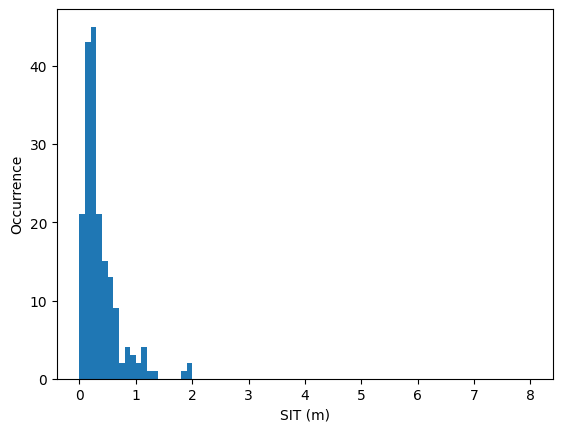

In [458]:
print(f'SIT for TOPAZ pixel "{mpix}": {sit_tp.isel(time=tidx,y=148,x=38).data} m')
print(f'SIT averaged for ICESat-2: {np.mean(sit_is[dmacc[mpix]].to_numpy())} m')
print(f'Histogram for {len(dmacc[mpix])} profiles from ICESat-2:')
plt.hist(sit_is[dmacc[mpix]], bins=bins)
plt.xlabel('SIT (m)')
plt.ylabel('Occurrence');

In [179]:
# n profiles per grid point
nproff = np.zeros((maskk.shape))

In [180]:
for item in list(dmacc.keys()):
    my = int(item.split('_')[0])
    mx = int(item.split('_')[1])
    nproff[my, mx] = len(dmacc[item])

NameError: name 'dmacc' is not defined

In [461]:
nprof = xr.DataArray(nproff,
                coords=maskk.coords, 
                dims=maskk.dims)

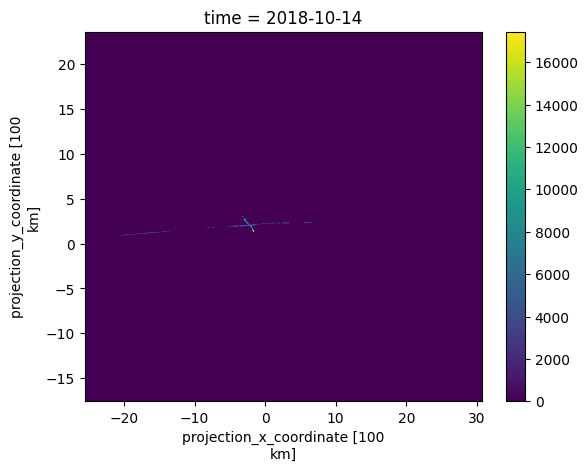

In [462]:
nprof.plot()

----------------------

# ------------------------------------------------------

## ATL10 Import for .h5

In [12]:
import h5py

In [13]:
h5 = h5py.File(filename, 'r')

In [ ]:
h5['orbit_info']['sc_orient'][:]

In [ ]:
# if ATLAS orientation:
#    - Forward (+X)  : Strong beams are R
#    - Backward (-X) : Strong beams are L

In [20]:
sc_orient = h5['orbit_info']['sc_orient'][:]

if sc_orient == 1:
    print('ATLAS Orientation Forward')
    beam1 = 'gt1r'
elif sc_orient == 0:
    print('ATLAS Orientation Backward')
    beam1 = 'gt1l'
    

ATLAS Orientation Forward


# ------------------------------------------------------